
#<center>   TensorFlow Warmup </center>  

<center>  <img src=https://drive.google.com/uc?id=1z9vxRHhKb40UK1xCL7kyEaPNjz7oaa5j " width="700">  </center> 
  
  <center>  <img src=https://drive.google.com/uc?id=1XzeE3TwD70_IfBiAhB0m8RayXmd_BD9j  width="700">  </center> 

#### Personal Contacts: 

[LinkedIn](https://www.linkedin.com/in/cristiano-de-nobili/), [GitHub](https://github.com/denocris),[ Instagram](https://www.instagram.com/denocris/?hl=it)


#### What are we going to learn in this notebook?

* Working on Google Colaboratory

* Build a simple model in TensorFlow 2.0

* (Build a simple model in TensorFlow Low-Level APIs)  


In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
#mnist = tf.keras.datasets.mnist

     |████████████████████████████████| 332.1MB 62kB/s 
     |████████████████████████████████| 61kB 19.9MB/s 
     |████████████████████████████████| 3.0MB 36.8MB/s 
     |████████████████████████████████| 419kB 43.5MB/s 


## Standard Pipeline to Build a Model

In the following two sections, we will learn how to build a model in TensorFlow.

* importing data;
* build the model chosen;
* define a loss function and an optimization procedure;
* training and evaluation
* inference 

We will start not exactly with a Neural Network but with a **Linear Model**. Then, we will apply what learned on a MNIST classification using a simple CNN.

## Simple Linear Model

We build a simple linear model: f(x) = x * W + b, which has just two variables, $W$ and $b$, to be leanrned. To train it, we prepare some data such that a well trained model would have $W = 3.0$ and $b = 2.0$. The idea is to learn the standard pipeline.

In [0]:
class simpleLinearModel(object):
  def __init__(self):
    # Initialize variable to (5.0, 0.0)
    self.W = tf.Variable(10.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.W * x + self.b

model = simpleLinearModel()

assert model(3.0).numpy() == 30.0
model([1.0,2.0,3.0]).numpy()

array([10., 20., 30.], dtype=float32)

We now define a loss function which measures how well the output of a model for a given input matches the desired output (the ground truth). In this case, let's use the standard L2 loss.

In [0]:
def loss(predicted_y, desired_y):
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

### Generate some data

In [0]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

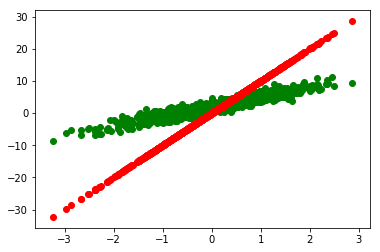

Current loss: 
51.67908


In [0]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='g')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

Here we are going to manually implement backpropagation as an alternative to the suggested tf.train.Optimizer implementations. 

In [0]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.W, model.b])
  # Update model.W by subtracting learning_rate*dW from it
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

Epoch  0: W=10.00 b=0.00, loss=51.67908
Epoch  5: W=5.43 b=1.36, loss=7.00354
Epoch 10: W=3.85 b=1.79, loss=1.71520
Epoch 15: W=3.31 b=1.93, loss=1.08811
Epoch 20: W=3.12 b=1.97, loss=1.01363
Epoch 25: W=3.05 b=1.99, loss=1.00477
Epoch 30: W=3.03 b=1.99, loss=1.00372
Epoch 35: W=3.02 b=1.99, loss=1.00359
Epoch 40: W=3.02 b=1.99, loss=1.00358
Epoch 45: W=3.02 b=2.00, loss=1.00358


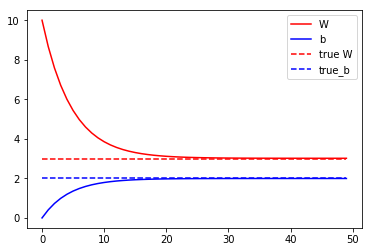

In [0]:
model = simpleLinearModel()

# Collect the history of W-values, b-values, loss-values to plot later
Ws, bs, loss_plot = [], [], []


epochs = range(50)
lr = 0.1

for epoch in epochs:
  
  current_loss = loss(model(inputs), outputs)
  
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  loss_plot.append(current_loss) 

  train(model, inputs, outputs, learning_rate=lr)
  if epoch % 5 == 0:
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
          (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()

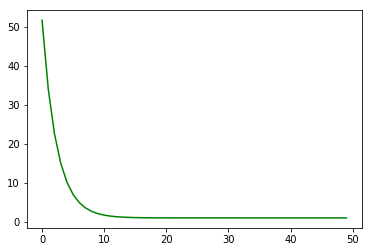

In [0]:
plt.plot(epochs, loss_plot, 'g')

## Simple CNN Classifier MNIST Dataset - Using High-Level APIs

### MNIST Dataset
First of all let's prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

<center>  <img src=https://drive.google.com/uc?id=1JJ0PgAwFNjlgAr3ROy8lgilHQW-iTXST " width="500">  </center> 

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11493376/11490434 [==============================] - 0s 0us/step


Use `tf.data` to batch and shuffle the dataset:

In [0]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

### Define the CNN and the Optimizer

Build the `tf.keras` model using the Keras model subclassing API (TF 2.0 is naturally integrated with Keras)

In [0]:
class simpleCNN(tf.keras.Model):
  def __init__(self):
    super(simpleCNN, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
    self.flatten = tf.keras.layers.Flatten()
    self.d1 = tf.keras.layers.Dense(128, activation='relu')
    self.d2 = tf.keras.layers.Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = simpleCNN()

Choose an optimizer (way to perform SGD) and loss function for training: 

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Training 

Let's define our training step

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Do the same for testing...

In [0]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [0]:
EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

Epoch 1, Loss: 0.14065921306610107, Accuracy: 95.79332733154297, Test Loss: 0.06076539680361748, Test Accuracy: 97.98999786376953
Epoch 2, Loss: 0.09295512735843658, Accuracy: 97.20833587646484, Test Loss: 0.057224199175834656, Test Accuracy: 98.13999938964844
Epoch 3, Loss: 0.06932837516069412, Accuracy: 97.91166687011719, Test Loss: 0.058035388588905334, Test Accuracy: 98.1433334350586
Epoch 4, Loss: 0.05553597956895828, Accuracy: 98.31500244140625, Test Loss: 0.06141255423426628, Test Accuracy: 98.15250396728516
Epoch 5, Loss: 0.04640030115842819, Accuracy: 98.5826644897461, Test Loss: 0.06264720857143402, Test Accuracy: 98.22000122070312


### A note on @tf.function

Use tf.function to make graphs out of your programs.

Suppose you want to add two tensors and let this operation be part of the TensorFlow Graph. The correct way to do it is

In [0]:
tf.add(tf.ones([2, 2]), tf.ones([2, 2]))

<tf.Tensor: id=59868, shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In Tensorflow 2.0 you have another possibility. You can define an usual python function using *def* and covert it as a TensorFlow operation with the decorator @tf.function.

In [0]:
# A function is like an op

@tf.function
def add(a, b):
  return a + b

add(tf.ones([2, 2]), tf.ones([2, 2]))  #  [[2., 2.], [2., 2.]]

<tf.Tensor: id=59914, shape=(2, 2), dtype=float32, numpy=
array([[3., 3.],
       [3., 3.]], dtype=float32)>

Now that our function is a tensorflow operation, we can compute its gradient with tf.GradientTape()

In [0]:
@tf.function
def add(a, b):
  return 5*a + b

v = tf.Variable(1.0)
with tf.GradientTape() as tape:
  result = add(v, 1.0)
tape.gradient(result, v)

<tf.Tensor: id=59985, shape=(), dtype=float32, numpy=5.0>

### A note about super().__init__()

It's about subclasses and inheritance. Inheritance is a concept in OOP in which a class derives (or inherits) attributes and behaviors from another class without needing to implement them again.
super() can take two parameters: the first is the subclass, and the second parameter is an object that is an instance of that subclass.

In [0]:
class Rectangle:
    def __init__(self, length, width):
        self.length = length
        self.width = width

    def area(self):
        return self.length * self.width

    def perimeter(self):
        return 2 * self.length + 2 * self.width

# With Square(Rectangle)we declare that the Square class inherits from the Rectangle class

class Square(Rectangle):
    def __init__(self, length):
        super(Square, self).__init__(length, length)
        
# We’ve used super() to call the __init__() of the Rectangle class, allowing you to use it in the Square class without repeating code.
        
 
sq = Square(4)

sq.area()

16

## Simple CNN Classifier MNIST Dataset  - Using Low Level API: Graph & Session

In [0]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
tf.__version__

'1.13.1'


TensorFlow represent computations as graphs. Nodes in the graph are called ops (operations). An op takes zero or more Tensors and produces zero or more Tensors as output. A Tensor is a multidimensional array with a specified type. The graph is a description of a computation, in order to actually execute the computation a graph must be launched in a session. A session execute a specific graph on one of the available devices (that can be either CPUs or GPUs).

Details about TensorFlow Low-Level APIs can be found in the *Appendix A* notebook.



In [0]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

keep_prob = tf.placeholder(tf.float32)


x_image = tf.reshape(x, [-1,28,28,1])

In [0]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
  
## ----------------------------------------------------------------
  
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [0]:
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  
h_pool1 = max_pool_2x2(h_conv1)



W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)



In [0]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [0]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [0]:

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
STEPS = 250

init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init)
  #for i in range(STEPS):
  for i in range(STEPS):
      batch = mnist.train.next_batch(BATCH_SIZE)
      if i%50 == 0:
          train_accuracy = sess.run(accuracy, feed_dict={x:batch[0], 
                                                         y_:batch[1], 
                                                         keep_prob: 1.0})
          print("step %d, training accuracy %g"%(i, train_accuracy))
      sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.125
step 50, training accuracy 0.65625
step 100, training accuracy 0.78125
step 150, training accuracy 0.84375
step 200, training accuracy 0.90625
